In [1]:
import pandas as pd
import numpy as np
import io, re
from unidecode import unidecode
from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize

In [2]:
archive = "Corpus.csv"

In [3]:
with open(archive, 'r') as myfile:
    data = myfile.read().encode('latin1').decode('utf8')
    df = pd.read_csv(io.StringIO(re.sub('"\s*\n','"',data)), delimiter=',')

In [4]:
df.head(10)

,#,Frases,Tipo,Resposta,Ação a ser Realizada,Ações Necessárias
0,1,Ligar luz,Explicito,Acendendo a lâmpada.,Acender a Lâmpada,Acender a Lâmpada
1,2,Ligar a luz,Explicito,Acendendo a lâmpada.,Acender a Lâmpada,Apagar Lâmpada
2,3,Iluminar o ambiente,Implicito,Deseja acender a lâmpada?,Acender a Lâmpada,Ligar Ventilador
3,4,Já está claro o dia!,Implicito,Apagando a lâmpada.,Apagar Lâmpada,Desligar Ventilador
4,5,Vamos economizar energia?,Implicito,Deseja apagar a lâmpada?,Apagar Lâmpada,Ligar Televisão
5,6,"Casa, apague a luz",Explicito,Apagando a lâmpada.,Apagar Lâmpada,Desligar Televisão
6,7,O ar está muito parado,Implicito,Ligando o ventilador.,Ligar Ventilador,Aumentar Volume
7,8,Está muito quente aqui,Implicito,Ligando o ventilador.,Ligar Ventilador,Diminuir Volume
8,9,Que calor!,Implicito,Deseja ligar o ventilador?,Ligar Ventilador,Mudar Canal
9,10,"Está muito barulho, desligue o ventilador",Explicito,Desligando o ventilador.,Desligar Ventilador,NaN


In [5]:
df = df.drop(columns=['#', 'Ações Necessárias'])

In [6]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [7]:
df['Frases'] = df['Frases'].apply(unidecode)

In [8]:
def replace_i(v):
    return v.replace('í', 'i')

In [9]:
df['Tipo'] = df['Tipo'].apply(replace_i)

In [10]:
df.head(5)

,Frases,Tipo,Resposta,Ação a ser Realizada
0,Ligar luz,Explicito,Acendendo a lâmpada.,Acender a Lâmpada
1,Ligar a luz,Explicito,Acendendo a lâmpada.,Acender a Lâmpada
2,Iluminar o ambiente,Implicito,Deseja acender a lâmpada?,Acender a Lâmpada
3,Ja esta claro o dia!,Implicito,Apagando a lâmpada.,Apagar Lâmpada
4,Vamos economizar energia?,Implicito,Deseja apagar a lâmpada?,Apagar Lâmpada


In [11]:
X = df['Frases'].tolist()
Y1 = df['Ação a ser Realizada'].tolist()
Y2 = df['Resposta'].tolist()
Y3 = df['Tipo'].tolist()

In [12]:
#Testando somente frases implícitas.
filteredExplicit = df[df.Tipo == 'Explicito']
filteredImplicit = df[df.Tipo == 'Implicito']
X_imp = filteredImplicit['Frases'].tolist()
X_exp = filteredExplicit['Frases'].tolist()
Y1_imp = filteredImplicit['Ação a ser Realizada'].tolist()
Y1_exp = filteredExplicit['Ação a ser Realizada'].tolist()
Y2_imp = filteredImplicit['Resposta'].tolist()
Y2_exp = filteredExplicit['Resposta'].tolist()

In [13]:
# Todas as frases
X = df['Frases'].tolist()
Y1 = df['Ação a ser Realizada'].tolist()
Y2 = df['Resposta'].tolist()
Y3 = df['Tipo'].tolist()

In [14]:
len(set(Y1)), len(set(Y2)), len(set(Y3))

(9, 18, 2)

# preprocessing data

In [15]:
# !pip install -U scikit-learn

# !pip install gensim

# !pip install nltk

In [16]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Y1)

Y1_encoded = le.transform(Y1)

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

X_tfidf = vectorizer.fit_transform(X)

# using word embeddings

In [17]:
w2v = KeyedVectors.load_word2vec_format('glove_s100.txt')

In [18]:
def transform_w2v(X):
    X_w2v = []
    for sentence in X:
        tokens = word_tokenize(sentence)
        vectors = []
        for token in tokens:
            try:
                vectors.append(w2v.get_vector(token.lower()))
            except:
                print(token)
            
        X_w2v.append(np.mean(vectors, axis=0))
    return X_w2v

X_w2v = transform_w2v(X)

escuridao
ventilacao
friiiiio


In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_w2v, Y1_encoded, test_size=0.25, random_state=42, stratify=Y1_encoded)

# Experiments with classification algorithms

In [20]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV

In [21]:
import warnings
warnings.filterwarnings('ignore')
params_lr = {'penalty': ['l1', 'l2'], 'C': [0.1, 0.5, 1, 10, 50], 'fit_intercept': [True, False],
             'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

params_svc = {'C': [0.1, 0.5, 1, 10, 50], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
             'shrinking': [True, False], 'probability': [True, False]}

params_knn = {'n_neighbors': [9, 11, 13, 15], 'weights':['uniform', 'distance'],
             'algorithm': ['auto', 'ball_tree', 'kd_tree'], 'p': [1,2]}

params_tree = {'criterion': ['gini', 'entropy'], 'splitter':['best', 'random'],
               'max_features': ['auto', 'sqrt', 'log2']}

params_clf = {'learning_rate': [0.1, 0.5, 1],
              'n_estimators': [10, 25], 'criterion':['friedman_mse', 'mse', 'mae'],
              'min_samples_split': [2, 5], 'max_depth':[3,5], 'max_features':['auto', 'sqrt', 'log2']}

lr = LogisticRegression()
svm = SVC()
knn = KNeighborsClassifier()
tree = tree.DecisionTreeClassifier()
clf = GradientBoostingClassifier()

gs_lr = GridSearchCV(lr, params_lr)
gs_lr.fit(X_train, y_train)
gs_svm = GridSearchCV(svm, params_svc)
gs_svm.fit(X_train, y_train)
gs_knn = GridSearchCV(knn, params_knn)
gs_knn.fit(X_train, y_train)
gs_tree = GridSearchCV(tree, params_tree)
gs_tree.fit(X_train, y_train)
gs_clf = GridSearchCV(clf, params_clf)
gs_clf.fit(X_train, y_train)

GridSearchCV(estimator=GradientBoostingClassifier(),
             param_grid={'criterion': ['friedman_mse', 'mse', 'mae'],
                         'learning_rate': [0.1, 0.5, 1], 'max_depth': [3, 5],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_split': [2, 5],
                         'n_estimators': [10, 25]})

In [22]:
#Anotar Hiperparâmetros para cada uma das Execuções.
print(gs_lr.best_params_)
print(gs_svm.best_params_)
print(gs_knn.best_params_)
print(gs_tree.best_params_)
print(gs_clf.best_params_ )

{'C': 10, 'fit_intercept': True, 'penalty': 'l2', 'solver': 'liblinear'}
{'C': 10, 'kernel': 'linear', 'probability': True, 'shrinking': True}
{'algorithm': 'auto', 'n_neighbors': 9, 'p': 2, 'weights': 'distance'}
{'criterion': 'gini', 'max_features': 'auto', 'splitter': 'random'}
{'criterion': 'friedman_mse', 'learning_rate': 0.1, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 25}


In [23]:
lr = gs_lr.best_estimator_
svm = gs_svm.best_estimator_ 
knn9 = gs_knn.best_estimator_ 
tree = gs_tree.best_estimator_ 
clf = gs_clf.best_estimator_

y_pred_lr = lr.predict(X_test)
y_pred_svm = svm.predict(X_test)
y_pred_knn9 = knn9.predict(X_test)
y_pred_tree = tree.predict(X_test)
y_pred_grad = clf.predict(X_test)

['Acender a Lâmpada' 'Apagar Lâmpada' 'Aumentar Volume'
 'Desligar Televisão' 'Desligar Ventilador' 'Diminuir Volume'
 'Ligar Televisão' 'Ligar Ventilador' 'Mudar Canal']


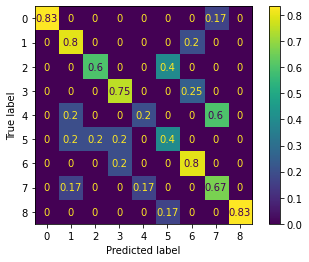

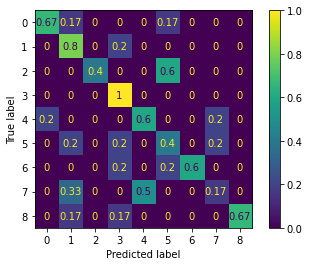

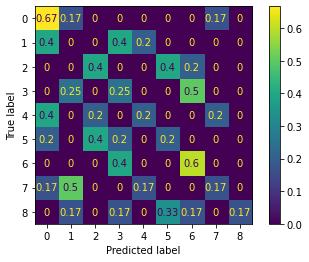

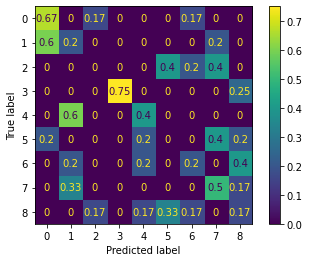

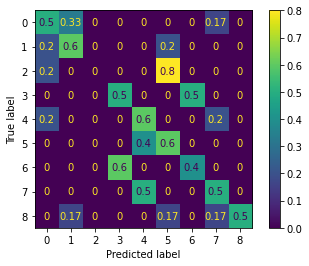

In [24]:
print(le.inverse_transform([0, 1, 2, 3, 4, 5, 6, 7, 8]))
plot_confusion_matrix(lr, X_test, y_test, normalize='true')
plot_confusion_matrix(svm, X_test, y_test, normalize='true')
plot_confusion_matrix(knn9, X_test, y_test, normalize='true')
plot_confusion_matrix(tree, X_test, y_test, normalize='true')
plot_confusion_matrix(clf, X_test, y_test, normalize='true')

In [25]:
scores_lr = cross_val_score(lr, X_train, y_train, cv=5)
scores_svm = cross_val_score(svm, X_train, y_train, cv=5)
scores_knn9 = cross_val_score(knn9, X_train, y_train, cv=5)
scores_tree = cross_val_score(tree, X_train, y_train, cv=5)
scores_clf = cross_val_score(clf, X_train, y_train, cv=5)

In [26]:
print("LR %0.2f accuracy with a standard deviation of %0.2f" % (scores_lr.mean(), scores_lr.std()))
print("SVM %0.2f accuracy with a standard deviation of %0.2f" % (scores_svm.mean(), scores_svm.std()))
print("KNN %0.2f accuracy with a standard deviation of %0.2f using %d neighbors" % (scores_knn9.mean(), scores_knn9.std(), 9))
print("Tree %0.2f accuracy with a standard deviation of %0.2f " % (scores_tree.mean(), scores_tree.std()))
print("Gradient Boosting %0.2f accuracy with a standard deviation of %0.2f " % (scores_clf.mean(), scores_clf.std()))

LR 0.62 accuracy with a standard deviation of 0.07
SVM 0.59 accuracy with a standard deviation of 0.09
KNN 0.42 accuracy with a standard deviation of 0.03 using 9 neighbors
Tree 0.25 accuracy with a standard deviation of 0.10 
Gradient Boosting 0.41 accuracy with a standard deviation of 0.12 


In [27]:
from sklearn.metrics import classification_report

for i, c in enumerate(list(le.classes_)):
    print(i, c)

In [28]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.57      0.80      0.67         5
           2       0.75      0.60      0.67         5
           3       0.60      0.75      0.67         4
           4       0.50      0.20      0.29         5
           5       0.40      0.40      0.40         5
           6       0.67      0.80      0.73         5
           7       0.50      0.67      0.57         6
           8       1.00      0.83      0.91         6

    accuracy                           0.66        47
   macro avg       0.67      0.65      0.64        47
weighted avg       0.68      0.66      0.65        47



In [29]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.80      0.67      0.73         6
           1       0.44      0.80      0.57         5
           2       1.00      0.40      0.57         5
           3       0.50      1.00      0.67         4
           4       0.50      0.60      0.55         5
           5       0.29      0.40      0.33         5
           6       1.00      0.60      0.75         5
           7       0.33      0.17      0.22         6
           8       1.00      0.67      0.80         6

    accuracy                           0.57        47
   macro avg       0.65      0.59      0.58        47
weighted avg       0.66      0.57      0.57        47



In [30]:
print(classification_report(y_test, y_pred_knn9))

              precision    recall  f1-score   support

           0       0.40      0.67      0.50         6
           1       0.00      0.00      0.00         5
           2       0.40      0.40      0.40         5
           3       0.14      0.25      0.18         4
           4       0.33      0.20      0.25         5
           5       0.20      0.20      0.20         5
           6       0.43      0.60      0.50         5
           7       0.33      0.17      0.22         6
           8       1.00      0.17      0.29         6

    accuracy                           0.30        47
   macro avg       0.36      0.29      0.28        47
weighted avg       0.38      0.30      0.29        47



In [31]:
print(classification_report(y_test, y_pred_tree))

              precision    recall  f1-score   support

           0       0.50      0.67      0.57         6
           1       0.14      0.20      0.17         5
           2       0.00      0.00      0.00         5
           3       1.00      0.75      0.86         4
           4       0.40      0.40      0.40         5
           5       0.00      0.00      0.00         5
           6       0.25      0.20      0.22         5
           7       0.38      0.50      0.43         6
           8       0.17      0.17      0.17         6

    accuracy                           0.32        47
   macro avg       0.31      0.32      0.31        47
weighted avg       0.30      0.32      0.31        47



In [32]:
print(classification_report(y_test, y_pred_grad))

              precision    recall  f1-score   support

           0       0.50      0.50      0.50         6
           1       0.50      0.60      0.55         5
           2       0.00      0.00      0.00         5
           3       0.40      0.50      0.44         4
           4       0.38      0.60      0.46         5
           5       0.33      0.60      0.43         5
           6       0.50      0.40      0.44         5
           7       0.50      0.50      0.50         6
           8       1.00      0.50      0.67         6

    accuracy                           0.47        47
   macro avg       0.46      0.47      0.44        47
weighted avg       0.47      0.47      0.45        47



In [33]:
# !pip install mlxtend

In [34]:
import warnings
warnings.filterwarnings('ignore')

from mlxtend.evaluate import paired_ttest_5x2cv
methods = []
methods.append(["Logistic Regression", lr])
methods.append(["SVM", svm])
methods.append(["KNN", knn9])
methods.append(["Decision Trees", tree])
methods.append(["Gradient Boosting", clf])

for i in range(0, len(methods)):
    for j in range(i+1, len(methods)):
        t, p = paired_ttest_5x2cv(estimator1 = methods[i][1],
                                  estimator2 = methods[j][1],
                                  X=X_w2v, y=Y1,
                                  random_seed=1)
        print(str(methods[i][0]) + " x " + str(methods[j][0]))
        print('t statistic: %.3f' % t)
        print('p value: %.3f' % p)
        print()

Logistic Regression x SVM
t statistic: -0.192
p value: 0.855

Logistic Regression x KNN
t statistic: 2.301
p value: 0.070

Logistic Regression x Decision Trees
t statistic: 6.007
p value: 0.002

Logistic Regression x Gradient Boosting
t statistic: 2.949
p value: 0.032

SVM x KNN
t statistic: 1.898
p value: 0.116

SVM x Decision Trees
t statistic: 3.142
p value: 0.026

SVM x Gradient Boosting
t statistic: 2.871
p value: 0.035

KNN x Decision Trees
t statistic: 2.626
p value: 0.047

KNN x Gradient Boosting
t statistic: -0.439
p value: 0.679

Decision Trees x Gradient Boosting
t statistic: -3.623
p value: 0.015

